# Time-Series MIA Example 

In [1]:
import os, sys, yaml, numpy as np, matplotlib.pyplot as plt, torch, pandas as pd

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from examples.mia.time_series_mia.utils.data_preparation import preprocess_dataset, get_dataloaders
from examples.mia.time_series_mia.utils.model_preparation import create_trained_model_and_metadata, predict
from examples.mia.time_series_mia.utils.set_seed import set_seed
from examples.mia.time_series_mia.utils.models.LSTM import LSTM
from examples.mia.time_series_mia.utils.models.TCN import TCN
from examples.mia.time_series_mia.utils.models.DLinear import DLinear
from examples.mia.time_series_mia.utils.models.NBeats import NBeats
from examples.mia.time_series_mia.utils.models.WaveNet import WaveNet
from examples.mia.time_series_mia.utils.models.Bromick import Bromick

from data_handler import IndividualizedInputHandler
from leakpro import LeakPro

/home/edgelab/LeakProZyzz/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
audit_config_path = "audit.yaml"
train_config_path = "train_config.yaml"

# Load the yaml files
with open(audit_config_path, 'r') as file:
    audit_config = yaml.safe_load(file)

with open(train_config_path, 'r') as file:
    train_config = yaml.safe_load(file)

In [3]:
random_seed = train_config["run"]["random_seed"]
log_dir = train_config["run"]["log_dir"]

epochs = train_config["train"]["epochs"]
batch_size = train_config["train"]["batch_size"]
optimizer = train_config["train"]["optimizer"]

lookback = train_config["data"]["lookback"]
horizon = train_config["data"]["horizon"]
num_individuals = train_config["data"]["num_individuals"]
train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
dataset_name = train_config["data"]["dataset"]
data_dir = train_config["data"]["data_dir"]
stride = train_config["data"]["stride"]
k_lead = train_config["data"]["k_lead"] # number of leading variables to use
num_time_steps = train_config["data"]["num_time_steps"] # number of time steps per individual

In [4]:
# Get data loaders
path = os.path.join(os.getcwd(), data_dir)
target_data_path = audit_config["target"]["data_path"]
target_data_file = os.path.basename(target_data_path) # Only look at file name of target data path
target_data_file = os.path.splitext(target_data_file)[0]

if target_data_file != dataset_name:
    raise Exception(f"Received unknown dataset or mismatching target file: dataset={dataset_name}, target={target_data_path}.")

set_seed(random_seed) # Set seed before and after, to ensure same randomness if you process or dont process dataset (dataset already processed)
dataset = preprocess_dataset(dataset_name, path, lookback, horizon, num_individuals, k_lead=k_lead, stride=stride, num_time_steps=num_time_steps)

set_seed(random_seed)
train_loader, test_loader = get_dataloaders(dataset, train_fraction, test_fraction, batch_size=batch_size)

Save data to /home/edgelab/LeakProZyzz/examples/mia/time_series_mia/../../../../data/EEG.pkl


In [5]:
# Train the model
input_dim = dataset.input_dim
model_name = audit_config["target"]["model_class"]

if model_name == "LSTM":
    model = LSTM(input_dim, horizon)
elif model_name == "TCN":
    model = TCN(input_dim, horizon)
elif model_name == "DLinear":
    model = DLinear(input_dim, lookback, horizon)
elif model_name == "NBeats":
    model = NBeats(input_dim, lookback, horizon)
elif model_name == "WaveNet":
    model = WaveNet(input_dim, horizon)
elif model_name == "Bromick" or model_name == "Bhowmick":
    model = Bromick(input_dim, horizon)
else:
    raise NotImplementedError()

train_loss, test_loss = create_trained_model_and_metadata(model, train_loader, test_loader, epochs, optimizer, dataset_name)

Training Progress: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


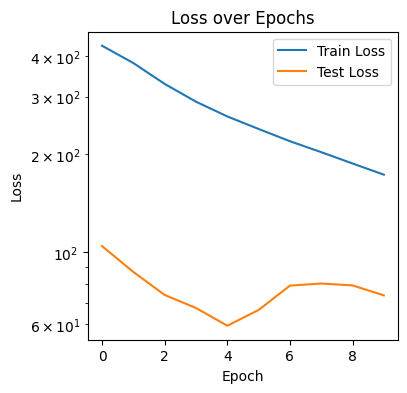

In [6]:
# Plot training and test loss
plt.figure(figsize=(4, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

### Plot metrics for final target model

In [7]:
from examples.mia.time_series_mia.utils.metrics import mse, rmse, nrmse, mae, nd
# Print metrics on final model, unscaled vs scaled, train and test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train = predict(model, train_loader, device, original_scale=False)
test  = predict(model, test_loader, device, original_scale=False)
unscaled_train = predict(model, train_loader, device, original_scale=True)
unscaled_test  = predict(model, test_loader, device, original_scale=True)

metrics, names = [mse, mae, rmse, nrmse, nd], ["MSE", "MAE", "RMSE", "NRMSE", "ND"]
values = [[m(*p) for m in metrics] for p in [train, test, unscaled_train, unscaled_test]]
print(pd.DataFrame(values, columns=names, index=["Train", "Test", "Unscaled train", "Unscaled test"]))

                         MSE       MAE       RMSE     NRMSE        ND
Train           1.662982e+02  6.424193  12.895665  0.981890  0.489145
Test            7.489421e+01  2.304464   8.654144  3.016078  0.803135
Unscaled train  1.174062e-06  0.000584   0.001084  0.879529  0.474185
Unscaled test   5.958501e-07  0.000220   0.000772  2.745990  0.783250


### Plotting sample predictions

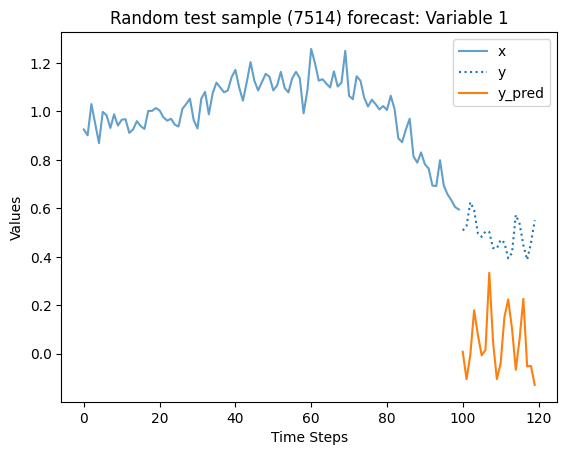

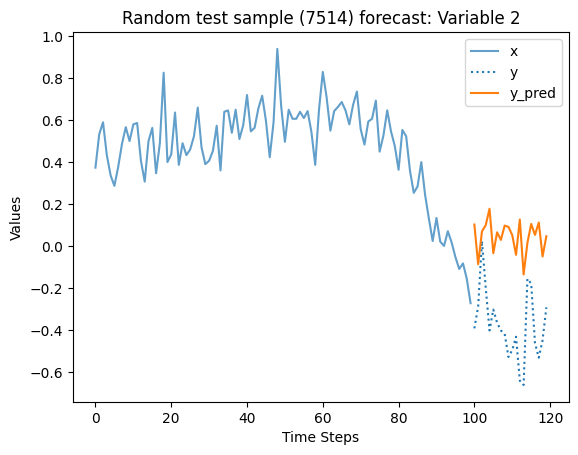

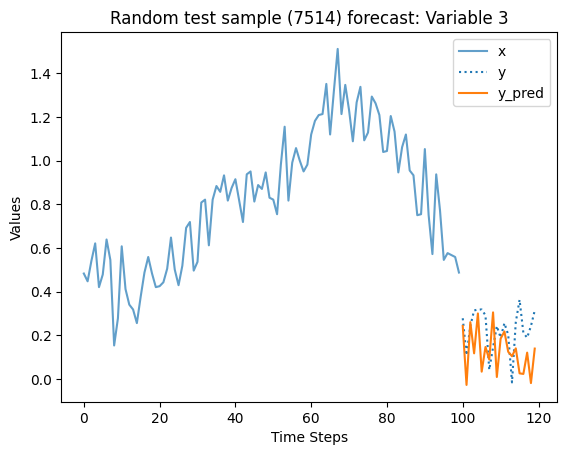

In [8]:
# Get random sample (re-execute for new one)
indices = test_loader.dataset.indices
random_sample_idx = np.random.choice(indices)
x = dataset.x[random_sample_idx,:,:].to(device)
y = dataset.y[random_sample_idx,:,:]
y_pred = model(x.unsqueeze(0)).detach().squeeze(0)

# Time axis
time_x = np.arange(lookback)
time_y = np.arange(lookback, lookback + horizon)

for i in range(y.shape[-1]):  # plot forecast for each variable in the series
    plt.plot(time_x, x[:, i].cpu().numpy(), label='x', alpha=0.7)  # lookback
    plt.plot(time_y, y[:, i], label='y', color='C0', linestyle='dotted')  # true horizon
    plt.plot(time_y, y_pred[:, i].cpu().numpy(), label='y_pred', color='C1')  # prediction

    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.legend()
    plt.title(f"Random test sample ({random_sample_idx}) forecast: Variable {i+1}")
    plt.show()

### Running MIA

In [9]:
# Prepare leakpro object
leakpro = LeakPro(IndividualizedInputHandler, audit_config_path)

# Run the audit 
mia_results = leakpro.run_audit(return_results=True)

2025-03-19 10:07:08,699 INFO     Target model blueprint created from LSTM in ./utils/models/LSTM.py.
2025-03-19 10:07:08,704 INFO     Loaded target model metadata from ./target/model_metadata.pkl
2025-03-19 10:07:08,709 INFO     Loaded target model from ./target
2025-03-19 10:07:08,731 INFO     Loaded population dataset from ../../../../data/EEG.pkl
2025-03-19 10:07:08,732 INFO     Loaded population dataset from ../../../../data/EEG.pkl
2025-03-19 10:07:08,877 INFO     MIA attack factory loaded.
2025-03-19 10:07:08,878 INFO     Creating shadow model handler singleton
2025-03-19 10:07:08,881 INFO     Creating distillation model handler singleton
2025-03-19 10:07:08,884 INFO     Added attack: lira
2025-03-19 10:07:08,885 INFO     Preparing attack: lira
2025-03-19 10:07:31,711 INFO     Training shadow model 65 on 4480 points
Epoch 10/10: 100%|██████████| 35/35 [00:00<00:00, 276.53it/s]
2025-03-19 10:07:33,487 INFO     Training shadow model 65 complete
2025-03-19 10:07:33,490 INFO     Save

### Generate report

In [ ]:
# Import and initialize ReportHandler
from leakpro.reporting.report_handler import ReportHandler

# report_handler = ReportHandler()
report_handler = ReportHandler(report_dir="./leakpro_output/results")

# Save MIA resuls using report handler
for res in mia_results:
    report_handler.save_results(attack_name=res.attack_name, result_data=res, config=res.configs)

# Create the report by compiling the latex text
report_handler.create_report()

2025-03-19 10:07:45,958 INFO     Initializing report handler...
2025-03-19 10:07:45,959 INFO     report_dir set to: ./leakpro_output/results
2025-03-19 10:07:45,959 INFO     Saving results for lira
2025-03-19 10:07:58,670 INFO     No results of type GIAResults found.
2025-03-19 10:07:58,671 INFO     No results of type SinglingOutResults found.
2025-03-19 10:07:58,672 INFO     No results of type InferenceResults found.
2025-03-19 10:07:58,673 INFO     No results of type LinkabilityResults found.
2025-03-19 10:08:04,849 INFO     PDF compiled


<Figure size 640x480 with 0 Axes>